#  Intracranial Hemorrhage Detection

## Model 4

#### Kristina Joos

---   

|                 	|                                                        	|
|:----------------:	|:-------------------------------------------------------:	|
| Model           	| VGG 16 (242x242)                                          |
| Preprocessing   	| Augementation Flip, Single Windowing                   	|
| Class Balancing 	| Oversampling                                           	|
| Loss Function   	| Binary_crossentropy                                      	|
| Regularization  	| Early Stopping, Drop Out Layers 0.3 	                    |
| Epochs Run      	| 50                                                     	|
| Time Run (min)   	| 60                                                       	|
|                 	|                                                        	|
| Test Sores      	| Accuracy: Loss:                                        	|
| Validation      	| Accuracy: Loss:                                        	|
| Leader Board    	| Score: Rank:                                           	|




In [26]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
#import tensorflow.keras
from tensorflow.keras import backend as K

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3




from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit



from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


#from tensorflow.nn import sigmoid_cross_entropy_with_logits



In [27]:
tf.test.is_gpu_available()

True

In [28]:
tf.test.is_built_with_cuda()

True

## Image Path

In [29]:
path_train_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [30]:
path_test_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'

In [31]:
def get_number_of_files(path, data_name):
    no =  len(os.listdir(path))
    print (f'The {data_name} contains {no} files.')

In [32]:
def get_size_directory(path, data_name):
    size = round(sum([os.path.getsize(f'{path}'+ f'{file}') for file in os.listdir(path)])*(10**-9), 2)
    print (f'The size of the {data_name} is {size} GB.')

In [33]:
print('***TRAIN DATA***')
get_size_directory(path_train_data, 'Training Data')
get_number_of_files(path_train_data, 'Training Data')

print('*******')

print('***TEST DATA***')
get_size_directory(path_test_data, 'Testing Data')
get_number_of_files(path_test_data, 'Testing Data')

print('*******')

print(f'We have {round(len(os.listdir(path_train_data))/len(os.listdir(path_test_data)),1)} times more train than test data.' )

***TRAIN DATA***
The size of the Training Data is 395.19 GB.
The Training Data contains 752803 files.
*******
***TEST DATA***
The size of the Testing Data is 63.64 GB.
The Testing Data contains 121232 files.
*******
We have 6.2 times more train than test data.


## Meta Data

In [34]:

train_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
# Test submission as test 
test_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

In [35]:
train_meta_df_shape = train_meta_df.shape
test_meta_df_shape = test_meta_df.shape

In [36]:
print(train_meta_df_shape)
print(test_meta_df_shape)

(4516842, 2)
(727392, 2)


## Parameters

In [37]:

# Seed
SEED = 11
np.random.seed(SEED)


# Constants
TEST_SIZE = 0.2
HEIGHT = 224 #VGG 16 has 256x256
WIDTH = 224
CHANNELS = 3
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 4
SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Folders
#DATA_DIR = '/kaggle/input/rsna-intracranial-hemorrhage-detection/'
PATH_TEST_DATA = path_test_data
PATH_TRAIN_DATA = path_train_data
PATH_PT_MODELS = '../models/predtrained models/'

In [193]:
# def rescale_pixelarray(dataset):
#     image = dataset.pixel_array
#     rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
#     rescaled_image[rescaled_image < -1024] = -1024
#     return rescaled_image
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    return dcm

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):

    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img
# def set_manual_window(hu_image, min_value, max_value):
#     hu_image[hu_image < min_value] = min_value
#     hu_image[hu_image > max_value] = min_value #max_value
#     return hu_image

class Preprocessor:    
    
    def __init__(self, path, augment=False):
        self.path = path
        self.nn_input_shape = (224,224,3) #was 256, 256
        #self.hu_min_value = hu_min_value
        #self.hu_max_value = hu_max_value
        self.augment = augment
        
  #load the dicom dataset
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(f'{self.path}{filename}')
        print(f'load_dicom_dataset {filename}')
        return dataset
    
    #Rescale the pixelarray to HU units and set to window
    
    def get_hounsfield_window(self, dataset):
        print(f'dataset get hounsfield{dataset}')
        hu_image = correct_dcm(dataset)
        windowed_image = bsb_window(hu_image)
        return windowed_image
        
#     def get_hounsfield_window(self, dataset, min_value, max_value):
#         try:
#             hu_image = rescale_pixelarray(dataset)
#             windowed_image = set_manual_window(hu_image, min_value, max_value)
#         except ValueError:
#             # set to level 
#             windowed_image = min_value * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
#         return windowed_image
        

    #Resize the image to the input shape of our CNN
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image

    #augment our image
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            #iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        print(f'filename preprocess{filename}')
        dataset = self.load_dicom_dataset(filename)
        print(f'dataset preprocess{dataset}')
        windowed_image = self.get_hounsfield_window(dataset)
        
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        #image = self.fill_channels(image)
        return image
    
#     def normalize(self, image):
#         return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5


In [194]:
def load_dicom_dataset(filename):
        dataset = pydicom.dcmread(filename)
        return dataset

In [195]:
a = load_dicom_dataset(path_train_data+"ID_ed64f0505.dcm")

In [196]:
a.BitsStored

16

In [197]:
train_meta_df.index.values


array([      0,       1,       2, ..., 4516839, 4516840, 4516841])

In [224]:
class Data_Generator(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=5,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = (224,224,4)
        self.preprocess_net = preprocess_vgg_16
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()

    def undersample(self):
        part = np.int(self.steps/4 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=2*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)

    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y_any, y_subtype = self.__generate_batch(current_ids)
        return X, [y_any, y_subtype]
    
    
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape))
        y_subtype = np.empty((self.batch_size, self.num_classes))
        y_any = np.empty((self.batch_size, 1))
        for idx, ident in enumerate(current_ids):
            # Store sample
            print(ident)
            image = self.preprocessor.preprocess(ident)
            X[idx] = image
            # Store class
            y_any[idx], y_subtype[idx] = self.__get_target(ident)
        return X, y_any, y_subtype
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        y_any = self.dataframe.loc[ident, "any"]
        y_subtype = self.dataframe.drop("any", axis=1).loc[ident].values
        return y_any, y_subtype

## Preparing Meta Data Frames


In [225]:
def make_usable_df(df):
    label = df.Label.values
    new_df = df.ID.str.rsplit("_", n=1, expand=True)
    new_df.loc[:, "label"] = label
    new_df = new_df.rename({0: "id", 1: "subtype"}, axis=1)
    piv_df = pd.pivot_table(new_df, index="id", columns="subtype", values="label")
    
    return piv_df


Check for Dupicates:

In [226]:
train_meta_df.duplicated().sum()

0

In [227]:
train_meta_df.drop_duplicates(inplace = True)

In [228]:
train_meta_df_shape[0] - train_meta_df.shape[0] == 24

True

Make usable Data Frame:

In [229]:
train_df = make_usable_df(train_meta_df)
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0



Check for Duplicates:

In [230]:
test_meta_df.duplicated().sum()

0

Make usable Data Frame:

In [231]:
test_df = make_usable_df(test_meta_df)
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


# Train/ Val Split

## Multi Label Stratified Shuffel Splitter 
Cross Validaor with stratification on multiple labels:
https://github.com/trent-b/iterative-stratification

In [232]:
msss = MultilabelStratifiedShuffleSplit(n_splits = 10, test_size = TEST_SIZE, random_state = SEED)
X = train_df.index
Y = train_df[['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural']].values

# Get train and test index
msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
val_idx = msss_splits[1]

In [233]:
train_idx.shape

(602242,)

In [234]:
val_idx.shape

(150561,)

In [235]:
train_data = train_df.iloc[train_idx]

In [236]:
train_data.shape

(602242, 6)

In [237]:
val_data = train_df.iloc[val_idx]

In [238]:
val_data.shape

(150561, 6)

## Custom Loan Functions

In [239]:
from tensorflow.python.ops import array_ops

In [240]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * K.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * K.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

## Make Model


In [241]:
def vgg_16():
    weights_path = '../models/predtrained models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    net = VGG16(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

In [242]:
my_vgg_16 = vgg_16()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: block4_conv1_6/kernel/Initializer/random_uniform/

In [243]:
class MakeModel:
    
    def __init__(self,
                 pt_model,
                 #loss,
                 metrics_list,
                 data_generator_train,
                 data_generator_val,
                 epochs,
                 num_classes=6,
                 checkpoint_path='../models/mymodels/'):
        
        self.pt_model = pt_model
        #self.loss = loss
        self.metrics_list = metrics_list
        self.data_generator_train = data_generator_train
        self.data_generator_val = data_generator_val
        self.epochs = epochs
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path 
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                            mode="min")
        self.earlystopping = EarlyStopping(monitor="val_loss",
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        base_model = self.pt_model
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=11),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=base_model.input, outputs=[any_pred, sub_pred])
        
        
    
    def compile_model(self):
        self.model.compile(optimizer=Adam(0.0001),
                           loss=['binary_crossentropy', focal_loss],
                           loss_weights = [1., 0.],
                           metrics=self.metrics_list)
    
    def fit_model(self):
        return self.model.fit_generator(generator = self.data_generator_train,
                    validation_data=self.data_generator_val,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint,self.earlystopping],
                    use_multiprocessing=True,
                    workers=-1)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, data_generator_test):
        predictions = self.model.predict_generator(data_generator_test, use_multiprocessing = True, workers=-1)
        return predictions

In [244]:
train_preprocessor = Preprocessor(path=PATH_TRAIN_DATA,
                                  #hu_min_value=0,
                                  #hu_max_value=100,
                                  augment=False)

In [245]:
val_preprocessor = Preprocessor(path=PATH_TRAIN_DATA,
                                  #hu_min_value=0,
                                  #hu_max_value=100,
                                  augment=False)

In [246]:
test_preprocessor = Preprocessor(path=PATH_TEST_DATA,
                                #hu_min_value=0,
                                #hu_max_value=100,
                                augment=False)

In [247]:
data_generator_train = Data_Generator(train_data,
                              train_preprocessor,
                              32,
                              shuffle=True,
                              steps=50)

data_generator_val = Data_Generator(val_data, 
                            val_preprocessor,
                            32,
                            shuffle=True,
                            steps=50)

data_generator_test= Data_Generator(test_df, 
                             test_preprocessor,
                             16,
                             shuffle=False)

In [248]:
train_data.loc[data_generator_train.data_ids].sum() / train_data.loc[data_generator_train.data_ids].shape[0]

subtype
any                 0.500000
epidural            0.011029
intraparenchymal    0.162990
intraventricular    0.118260
subarachnoid        0.162990
subdural            0.235294
dtype: float64

In [249]:
model4 = MakeModel(pt_model=my_vgg_16,
                      #loss="binary_crossentropy", #multilabel_focal_loss(class_weights=my_class_weights, alpha=0.5, gamma=0),
                      metrics_list={'any_predictions':['binary_crossentropy', 'accuracy'],
                                            'subtype_pred': [focal_loss, 'accuracy']},
                      data_generator_train = data_generator_train,
                      data_generator_val = data_generator_val,
                      epochs=200,
                      num_classes=5)
model4.build_model()
model4.compile_model()
model4_history = model4.fit_model()


Epoch 1/200
ID_ecb69d581
filename preprocessID_ecb69d581.dcm
load_dicom_dataset ID_ecb69d581.dcm
dataset preprocess(0008, 0018) SOP Instance UID                    UI: ID_ecb69d581
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_4dff7413'
(0020, 000d) Study Instance UID                  UI: ID_b98205b77a
(0020, 000e) Series Instance UID                 UI: ID_79ffc5552c
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-11', '201']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocate

ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224,4)

In [73]:
model2.model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

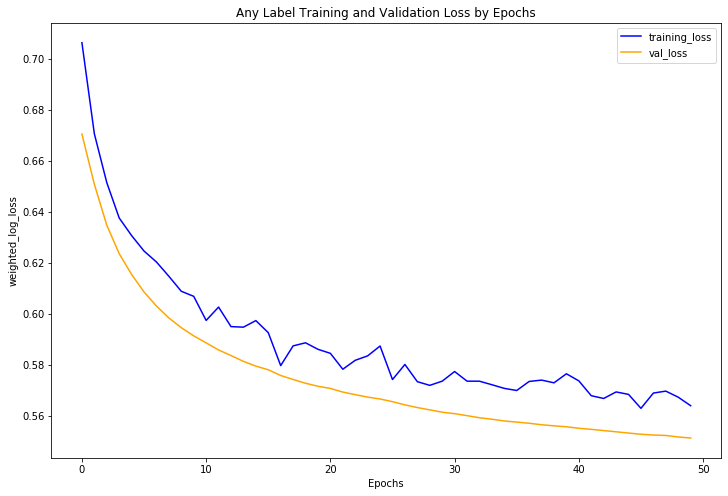

In [98]:
train_loss = model3_history.history['any_predictions_loss']
val_loss = model3_history.history['val_any_predictions_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Any Label Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

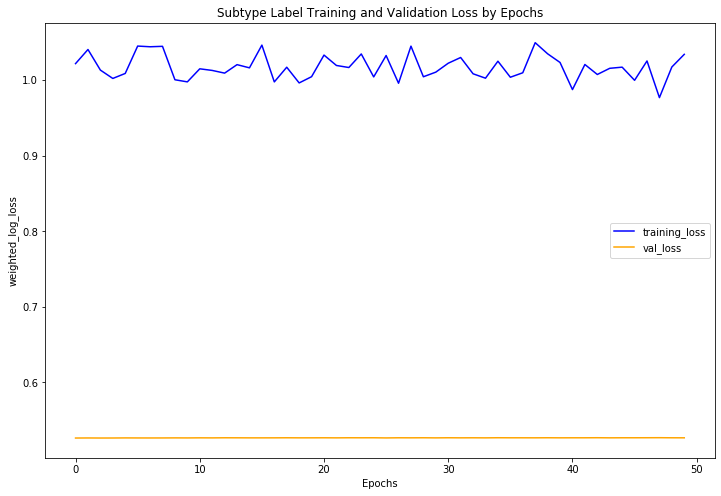

In [100]:
train_loss = model3_history.history['subtype_pred_loss']
val_loss = model3_history.history['val_subtype_pred_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Subtype Label Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

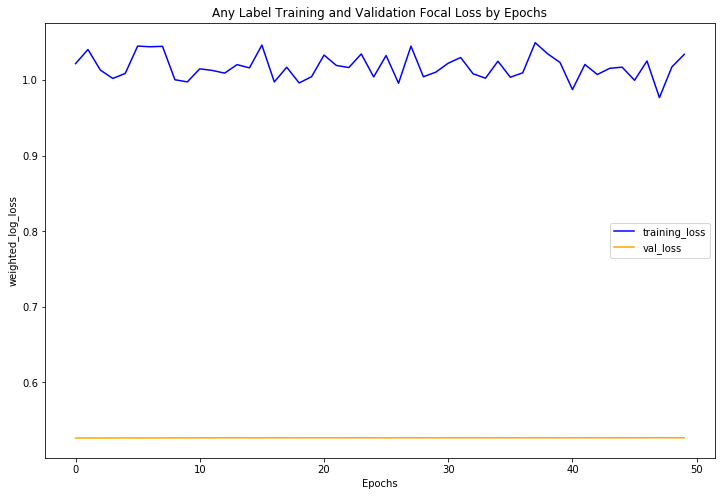

In [103]:
train_loss = model3_history.history['subtype_pred_focal_loss']
val_loss = model3_history.history['val_subtype_pred_focal_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Any Label Training and Validation Focal Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

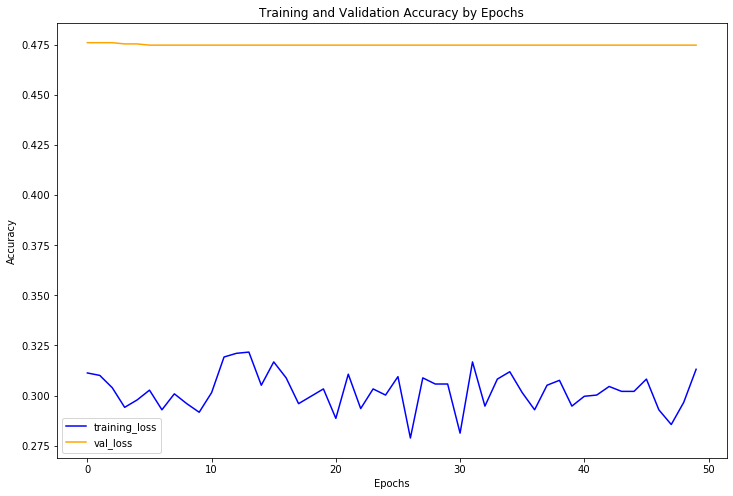

In [104]:
train_acc = model3_history.history['subtype_pred_accuracy']
val_acc = model3_history.history['val_subtype_pred_accuracy']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_acc', color = 'b')
plt.plot(val_loss, label = 'val_acc', color = 'orange')

plt.title('Training and Validation Subtype Accuracy by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [107]:
train_proba_any, train_proba_subtype = model3.predict(data_generator_test)

In [109]:
train_proba_any.shape

(121232, 1)

In [111]:
train_proba_subtype.shape

(121232, 5)

In [116]:
submission = np.concatenate((train_proba_any,train_proba_subtype),axis=1)

In [117]:
submission.shape

(121232, 6)

In [127]:
def make_df(meta_data_df, predictions):
    df = pd.DataFrame(predictions, columns=meta_data_df.columns, index=meta_data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    df = df[['ID','Label']]
   
    return df

In [128]:
submission_3 = make_df(test_df, submission)

In [131]:
submission_3.to_csv('../data/output/submissions/submission_model_3.csv', index=False)